# 1. Titanic (Regression)

* https://www.kaggle.com/c/titanic/overview
* 출력을 csv파일로 저장하여 함께 제출
* submit predictions에 테스트해 볼 것!
* 어떠한 알고리즘을 사용하여도 무방함
* 참조: https://www.kaggle.com/alexisbcook/getting-started-with-titanic

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# 데이터 로드
train_data = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')
gender_submission = pd.read_csv('./titanic/gender_submission.csv')

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 칼럼 출력
print(train_data.columns.values)
print(test.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [5]:
# 라벨 정의
labels = train_data['Survived'].values
labels = torch.tensor(labels)
labels[0:10]

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [6]:
# 칼럼 제거 (Pclass, Sex, Age, Embarked 이용)
train_df = train_data.drop(['PassengerId', 'Survived', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin'], axis=1)
test_df = test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin'], axis=1)

In [7]:
train_df

,Pclass,Sex,Age,Embarked
0,3,male,22.0,S
1,1,female,38.0,C
2,3,female,26.0,S
3,1,female,35.0,S
4,3,male,35.0,S
...,...,...,...,...
886,2,male,27.0,S
887,1,female,19.0,S
888,3,female,NaN,S
889,1,male,26.0,C


In [8]:
train_df.isnull().sum() # null 개수 출력

Pclass        0
Sex           0
Age         177
Embarked      2
dtype: int64

In [9]:
min(train_df['Age']),max(train_df['Age']) # Age 최소값, 최댓값 출력

(0.42, 80.0)

In [10]:
# Train Age 그룹화
train_df.loc[(train_df['Age'] > 0) & (train_df['Age'] <= 10), 'Age'] = 0
train_df.loc[(train_df['Age'] > 10) & (train_df['Age'] <= 20), 'Age'] = 1
train_df.loc[(train_df['Age'] > 20) & (train_df['Age'] <= 30), 'Age'] = 2
train_df.loc[(train_df['Age'] > 30) & (train_df['Age'] <= 40), 'Age'] = 3
train_df.loc[(train_df['Age'] > 40) & (train_df['Age'] <= 50), 'Age'] = 4
train_df.loc[(train_df['Age'] > 50) & (train_df['Age'] <= 60), 'Age'] = 5
train_df.loc[(train_df['Age'] > 60) & (train_df['Age'] <= 70), 'Age'] = 6
train_df.loc[(train_df['Age'] > 70) & (train_df['Age'] <= 80), 'Age'] = 7

# Train Age_null 칼럼 생성
Age_null=train_df.Age.isnull()
Age_null=pd.DataFrame(Age_null.replace({True: 1, False: 0}))
Age_null=Age_null.rename(columns={'Age':'Age_null'})

# Train Embarked_null 칼럼 생성
Embarked_null=train_df.Embarked.isnull()
Embarked_null=pd.DataFrame(Embarked_null.replace({True: 1, False: 0}))
Embarked_null=Embarked_null.rename(columns={'Embarked':'Embarked_null'})

# Train 칼럼 분해 (True = 1, False = 0), 생성한 칼럼 추가
train_df=pd.get_dummies(data = train_df, columns = ['Sex'], prefix = 'Sex')
train_df=pd.get_dummies(data = train_df, columns = ['Age'], prefix = 'Age')
train_df = pd.concat([train_df,Age_null],axis=1)
train_df=pd.get_dummies(data = train_df, columns = ['Pclass'], prefix = 'Pclass')
train_df=pd.get_dummies(data = train_df, columns = ['Embarked'], prefix = 'Embarked')
train_df = pd.concat([train_df,Embarked_null],axis=1)

In [11]:
# Test Age 그룹화
test_df.loc[(test_df['Age'] > 0) & (test_df['Age'] <= 10), 'Age'] = 0
test_df.loc[(test_df['Age'] > 10) & (test_df['Age'] <= 20), 'Age'] = 1
test_df.loc[(test_df['Age'] > 20) & (test_df['Age'] <= 30), 'Age'] = 2
test_df.loc[(test_df['Age'] > 30) & (test_df['Age'] <= 40), 'Age'] = 3
test_df.loc[(test_df['Age'] > 40) & (test_df['Age'] <= 50), 'Age'] = 4
test_df.loc[(test_df['Age'] > 50) & (test_df['Age'] <= 60), 'Age'] = 5
test_df.loc[(test_df['Age'] > 60) & (test_df['Age'] <= 70), 'Age'] = 6
test_df.loc[(test_df['Age'] > 70) & (test_df['Age'] <= 80), 'Age'] = 7

# Test Age_null 칼럼 생성
Age_null=test_df.Age.isnull()
Age_null=pd.DataFrame(Age_null.replace({True: 1, False: 0}))
Age_null=Age_null.rename(columns={'Age':'Age_null'})

# Test Embarked_null 칼럼 생성
Embarked_null=test_df.Embarked.isnull()
Embarked_null=pd.DataFrame(Embarked_null.replace({True: 1, False: 0}))
Embarked_null=Embarked_null.rename(columns={'Embarked':'Embarked_null'})

# Test 칼럼 분해 (True = 1, False = 0), 생성한 칼럼 추가
test_df=pd.get_dummies(data = test_df, columns = ['Sex'], prefix = 'Sex')
test_df=pd.get_dummies(data = test_df, columns = ['Age'], prefix = 'Age')
test_df = pd.concat([test_df,Age_null],axis=1)
test_df=pd.get_dummies(data = test_df, columns = ['Pclass'], prefix = 'Pclass')
test_df=pd.get_dummies(data = test_df, columns = ['Embarked'], prefix = 'Embarked')
test_df = pd.concat([test_df,Embarked_null],axis=1)

In [12]:
# Regression
model = SVC(kernel = 'linear', C=1, gamma = 0.1)
model.fit(train_df,labels)

SVC(C=1, gamma=0.1, kernel='linear')

In [13]:
# Test Survived values to DataFrame 
survived=pd.DataFrame(model.predict(test_df)).rename(columns={0:'Survived'})

In [14]:
# Train, Test 데이터 정의, 타입 변경
train_data=train_df.values
train_data=torch.from_numpy(train_data.astype('float32'))
test_data=test_df.astype({'Embarked_null':'int64'}).values
test_data=torch.from_numpy(test_data.astype('float32'))
train_data.shape, test_data.shape

(torch.Size([891, 18]), torch.Size([418, 18]))

In [15]:
# 모델 정의
model = torch.nn.Sequential(
    torch.nn.Linear(18, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1)
)
print(model)

Sequential(
  (0): Linear(in_features=18, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=2, bias=True)
  (3): Softmax(dim=1)
)


In [16]:
# learning_rate, criterion, optimizer 정의
learning_rate = 1e-4
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [15]:
# Training
for epoch in range(1000): 
    pred = model(train_data)
    loss = criterion(pred, labels) 
    optimizer.zero_grad()  
    loss.backward() 
    optimizer.step()
    
    correct = pred.max(1)[1] == labels # True인지 False인지 판단
    accuracy = correct.sum()/labels.size(0) # 정확도 계산
    
    if epoch % 100 == 0:
        print(f"\n Train Epoch: {epoch} \tLoss: {loss.item():.6f} \tAccuracy: {accuracy.item()*100:.6f}")


 Train Epoch: 0 	Loss: 0.712820 	Accuracy: 36.139169

 Train Epoch: 100 	Loss: 0.689513 	Accuracy: 53.423119

 Train Epoch: 200 	Loss: 0.666501 	Accuracy: 70.594835

 Train Epoch: 300 	Loss: 0.641710 	Accuracy: 74.859709

 Train Epoch: 400 	Loss: 0.615730 	Accuracy: 77.104378

 Train Epoch: 500 	Loss: 0.589983 	Accuracy: 80.583614

 Train Epoch: 600 	Loss: 0.567231 	Accuracy: 80.471379

 Train Epoch: 700 	Loss: 0.548929 	Accuracy: 80.246913

 Train Epoch: 800 	Loss: 0.534943 	Accuracy: 80.583614

 Train Epoch: 900 	Loss: 0.524601 	Accuracy: 80.583614


In [17]:
# Test, gender_submission 로드
test = pd.read_csv('./titanic/test.csv')
gender_submission = pd.read_csv('./titanic/gender_submission.csv')

In [17]:
# Test Survived values to DataFrame 
Survived=pd.DataFrame(model(test_data).max(1)[1]).rename(columns={0:'Survived'})

In [18]:
# PassengerId를 제외한 칼럼 제거
test_df = test.drop(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)

In [19]:
# PassengerId에 rSurvived 붙이기
test_df_SCV = pd.concat([test_df,survived],axis=1)
test_df_SCV

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [19]:
# PassengerId에 Survived 붙이기
test_df_ML = pd.concat([test_df,Survived],axis=1)
test_df_ML

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [20]:
# Regression Test 정확도 계산
correct = test_df_SCV['Survived'].values == gender_submission['Survived'].values
correct.sum()/len(test_df)*100

100.0

In [21]:
# Test csv 저장
test_df_SCV.to_csv('./titanic/titanic_SCV.csv', index=False)

In [20]:
# ML Test 정확도 계산
correct = test_df_ML['Survived'].values == gender_submission['Survived'].values
correct.sum()/len(test_df)*100

97.36842105263158

In [21]:
# Test csv 저장
test_df_ML.to_csv('./titanic/titanic_ML.csv', index=False)

# 2. Image classification with CNN

* cnn을 이용하여 다음 이미지를 분류하여라.
* 인풋 데이터는 rgb 정보를 가지고 있다.
* 코드, 결과, 보고서를 함께 제출하여야 한다.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torch.utils.data import Dataset, DataLoader
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
import time

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import ToTensor

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)


testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=torchvision.transforms.ToTensor()
)

# 평균과 분산 계산
mean = [np.mean(x.numpy(), axis=(1,2)) for x,_ in trainset]
std = [np.std(x.numpy(), axis=(1,2)) for x,_ in trainset]

mean0 = np.mean([m[0] for m in mean])
mean1 = np.mean([m[1] for m in mean])
mean2 = np.mean([m[2] for m in mean])

std0 = np.mean([s[0] for s in std])
std1 = np.mean([s[1] for s in std])
std2 = np.mean([s[2] for s in std])

print(mean0, mean1, mean2)
print(std0, std1, std2)

Files already downloaded and verified
Files already downloaded and verified
0.49139965 0.48215845 0.4465309
0.20220213 0.19931543 0.20086348


In [24]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean0,mean1,mean2), (std0,std1,std2)) # 계산된 평균과 분산을 이용하여 Normalize
                   ])
)


testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean0,mean1,mean2), (std0,std1,std2)) # 계산된 평균과 분산을 이용하여 Normalize
                   ])
)

batch_size = 32

train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size,
    shuffle=False
)
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


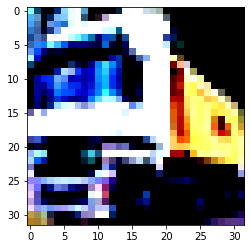

In [25]:
import matplotlib.pyplot as plt

images=train_loader.dataset[1][0]
plt.imshow(images.permute(1, 2, 0))

In [26]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # _, 32, 32, 32         
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # _, 32, 32, 32 
            nn.BatchNorm2d(32),            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # _, 32, 16, 16 
            nn.Dropout(0.3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # _, 64, 16, 16           
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # _, 64, 16, 16 
            nn.BatchNorm2d(64),            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # _, 64, 8, 8 
            nn.Dropout(0.5)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # _, 128, 8, 8             
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # _, 128, 8, 8 
            nn.BatchNorm2d(128),            
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # _, 128, 4, 4 
            nn.Dropout(0.5)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
    
        return x

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Network().to(device) # Network로 model 정의
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-3)

In [28]:
def train(model, epoch, train_loader, device, optimizer):
    model.train()
    for batch_i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 변화도를 0으로 만듦
        
        output = model(data)
        loss = F.cross_entropy(output, target)
        
        loss.backward() # 역전파 단계를 수행
        optimizer.step() # 가중치를 갱신
        
    if epoch % 20 == 0:        
        print(f"\n Train Epoch: {epoch} \tLoss: {loss.item():.6f}") # epoch 20의 배수마다 결과 출력
    return loss

In [29]:
def test(model, epoch, test_loader, device):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for batch_i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            pred = output.argmax(dim=1, keepdim=True) # 확률이 가장 큰 라벨 추론
            correct += pred.eq(target.view_as(pred)).sum().item() # target과 비교 후 True 개수 세기
            Accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산
    if epoch % 20 == 0:
        print(f"\nTest set: loss: {loss.item():.6f}, Accuracy: {correct}/{len(test_loader.dataset)}({(100. * correct / len(test_loader.dataset)):.2f}%)\n") # epoch 20의 배수마다 결과 출력
    return loss, Accuracy

In [30]:
train_loss=[]
test_loss=[]
test_Accuracy = []
def main():
    best_Accuracy = 0
    Accuracy = 0
    i = 0
    for epoch in range(1, epochs+1):
        best_Accuracy = max(best_Accuracy,Accuracy)  
        loss=train(model, epoch, train_loader, device, optimizer)
        train_loss.append(loss.detach())
        loss,Accuracy=test(model, epoch, test_loader, device)
        test_loss.append(loss)
        test_Accuracy.append(Accuracy)
        
        # best_Accuracy가 30번 동안 갱신이 안되면 train 멈춤
        if best_Accuracy >= Accuracy:
            i = i+1
        elif best_Accuracy < Accuracy:
            i = 0  
        if i == 30:
            break
    print(f"\nBest Accuracy: {max(test_Accuracy):.6f}\n")

In [31]:
epochs=1000
main()


 Train Epoch: 20 	Loss: 1.779206

Test set: loss: 1.646631, Accuracy: 8094/10000(80.94%)


 Train Epoch: 40 	Loss: 1.753926

Test set: loss: 1.678387, Accuracy: 8410/10000(84.10%)


 Train Epoch: 60 	Loss: 1.746634

Test set: loss: 1.607362, Accuracy: 8432/10000(84.32%)


 Train Epoch: 80 	Loss: 1.676470

Test set: loss: 1.594226, Accuracy: 8461/10000(84.61%)


 Train Epoch: 100 	Loss: 1.862911

Test set: loss: 1.567532, Accuracy: 8461/10000(84.61%)


 Train Epoch: 120 	Loss: 1.563278

Test set: loss: 1.563121, Accuracy: 8439/10000(84.39%)


 Train Epoch: 140 	Loss: 1.838419

Test set: loss: 1.531235, Accuracy: 8508/10000(85.08%)


 Train Epoch: 160 	Loss: 1.771715

Test set: loss: 1.614954, Accuracy: 8609/10000(86.09%)


 Train Epoch: 180 	Loss: 1.616829

Test set: loss: 1.492957, Accuracy: 8522/10000(85.22%)


Best Accuracy: 86.090000



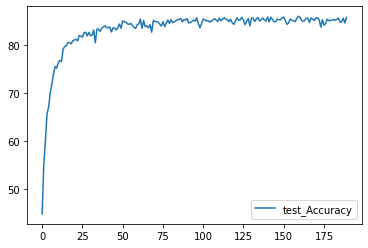

In [32]:
plt.plot(test_Accuracy,label='test_Accuracy')
plt.legend()

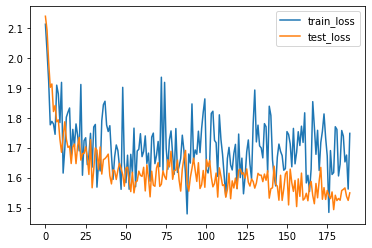

In [33]:
plt.plot(train_loss,label='train_loss')
plt.plot(test_loss,label='test_loss')
plt.legend()

torchvision.datasets을 이용해서 ./data 폴더에 있는 CIFAR-10을 불러온다. 처음에는 Nomarlize을 하기 위한 mean과 std를 모르기 때문에 기존의 데이터에서 계산한다. 이때 train data만 이용해야한다. 계산된 mean과 std를 train data와 test data에 적용하여 데이터를 Nomarlize 시킨다. Batch size는 32로 했으며, train_loader만 shuffle을 True로 설정한다.

기존의 (32,3,32,32) 데이터가 네트워크로 들어오면 self.layer1을 통과하면서 (32,32,16,16)으로 바뀐다. 자세히 설명해보면,   (32,3,32,32) 데이터가 Conv2d를 통과하면서 R,G,B 세 개의 채널이 32개의 채널로 늘어난다. 컨볼루션은 해당하는 요소끼리 곱해서 결과를 모두 더하는 선형 연산이다. Kernel size를 3, stride는 입력하지 않았기 때문에 기본값인 1이고,  컨볼루션을 통과하면서 dimension이 (32,32,30,30)이 되어야 하지만, padding을 1로 했기 때문에 이미지 크기의 dimension이 (32,32)로 변하지 않는다. 이 데이터는 BatchNorm2d(32)와 ReLU(inplace=True)를 통과하게 되는데, BatchNorm2d는 학습 과정에서 각 배치 단위 별로 데이터가 다양한 분포를 가지더라고 각 배치별로 평균과 분산을 이용해 정규화시킨다. ReLU는 Activation Function으로, 비선형 함수이다. 선형 함수가 아니라 비선형 함수를 사용하는 이유는 딥러닝 모델의 레이어 층을 깊게 가져갈 수 있기 때문이다. ReLU에선 x가 0보다 크면 기울기가 1인 직선, 0보다 작으면 함수 값이 0이 된다. 이는 0보다 작은 값들에서 뉴런이 죽을 수 있는 단점을 야기하지만 Sigmoid나 Tanh 함수보다 학습이 빠르고, 연산량이 적고, 구현이 매우 간단하다. ReLU에 inplace를 True로 함으로써 inplace 연산을 수행한다. Inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는 것을 의미한다.  이러한 과정을 한번 더 반복한 후 Max Pooling을 한다. pooling이란 일정 크기의 블록을 통합하여 하나의 대표값으로 대체하는 연산인데, Max Pooling은 최대값을 대표값으로 한다. Max Pooling 과정에서 dimension이 (32,32,32,32) 인 데이터가 (32,32,16,16)으로 바뀌며, image size가 반으로 줄어든다.  self.layer1의 마지막엔 Dropout(0.3)을 추가했다. 이는 각각의 뉴런이 0.3의 확률로 제거될지 말지 랜덤하게 결정된다.  Dropout은 어떤 특정한 Feature만을 과도하게 집중하여 학습함으로써 발생할 수 있는 overfitting을 방지하기 위해 사용된다. 이렇게 하나의 self.layer가 정의된다. self.layer2와 self.layer3도 self.layer1과 같은 구조다. 단지, 채널과 Dropout이 self.layer2에서 64, 0.5, self.layer3에서 128, 0.5로 바뀔 뿐이다. 그러면 self.layer1을 통과해서 나온 dimension이 (32,32,16,16)인 데이터가 self.layer2를 통과하면서 (32,64,8,8)이 되고, self.layer3을 통과하면서 (32,128,4,4)가 된다.

dimension이 (32,128,4,4)인 데이터는 torch.flatten(x, 1)를 통해 (32,128x4x4)로 바뀐다. 이는 FC에 넣기 위함이다. 그렇게 nn.Linear(128x4x4, 128)에 들어가고, 똑같이 BatchNorm과 ReLU, Dropout을 통과하는데 이때 BatchNorm1d이며, Dropout(0.5)로 설정했다. 이후  nn.Linear(128, 10)과 Softmax(dim=1)을 통과하면서 classes 개수의 확률로 표현이 된다.

Device는 cuda를 이용하는 컴퓨터에서 돌리기 위해 추가했으며, model에 network를 추가하여 .to(device)를 통해 gpu를 이용하게 만들었다. Optimizer은 Adam을 이용했고 learning rate=1e-4, weight decay=3e-3으로 설정했다.

train과 test에서 loss는 cross entropy를 이용했다. data와 target도 gpu를 사용하기 위해 .to(device)를 추가했으며, output은 네트워크를 통과한 classes 개수의 확률값이다. loss.backward()와 optimizer.step()를 통해 train을 할 때마다 loss가 줄어들도록 파라미터들이 optimize된다. test에서는 accuracy도 계산한다. output.argmax(dim=1, keepdim=True)를 통해 classes 개수의 확률값중 가장 큰 값의 차원을 출력한다. 즉, 머신이 어떤 classes로 판단을 했는지가 된다. keepdim을 True로 했기 때문에 dimension은 변하지 않는다. 이를 target과 비교해서 True인지 False인지 판단을 하고, correct로 True의 개수를 센다. 그리고 이를 전체 데이터 개수로 나눈다음 100을 곱함으로써 accuracy가 계산된다. Epoch % 20 == 0 을 통해 epoch 가 20의 배수일 때 마다 train에선 loss가, test에선 loss와 accuracy가 출력되게 했다.

test에서 최대 accuracy를 얻는 것이 목적이기 때문에, epoch는 1000으로 설정을 했다. 단, epoch가 30번 반복될동안 best accuracy가 갱신되지 않는다면 더 이상의 train은 의미가 없다고 판단하여 멈추도록 코드를 짰다. 최종적으로 train은 190번 반복됐으며, best accuracy는 epoch=160일 때 86.09%를 얻었다.